In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time
from typing import List
from __future__ import annotations  # Forward references automatically handled
from PIL import Image
from IPython.display import Image as IPImage, display
import os
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import shutil

In [17]:
# helper functions
def limit_vector_magnitude(vector, max_magnitude):
    magnitude = np.linalg.norm(vector)
    if magnitude > max_magnitude:
        return (vector / magnitude) * max_magnitude
    return vector

def get_distance(vector1, vector2):
    return np.linalg.norm(vector1 - vector2)

In [18]:
class Cage:
    def __init__(self, center_position=(0,0), radius = 500):
        self.position = np.asarray(center_position)
        self.tup_position = center_position
        self.radius = radius

In [19]:
from enum import Enum

class AgentType(Enum):
    AgentTypePredator = "PREDATOR"
    AgentTypePrey = "PREY"
    AgentTypeNone = "NONE"

In [20]:
class Agent:
    def __init__(self, position=(0,0), agent_type:AgentType = AgentType.AgentTypeNone):
        self.id = np.random.randint(100000)
        self.position = np.asarray(position)
        self.agent_type = agent_type
        self.initial_position = np.asarray(position)

    def step(self):
        return self.position

In [45]:
class Prey(Agent):
    def __init__(self, cage, position=(0,0), velocity=[0,0], behavior = 0):
        super().__init__(position, AgentType.AgentTypePrey)
        self.velocity = limit_vector_magnitude(np.asarray(velocity), 1)
        self.speed = 1
        self.behavior = behavior

        self.initial_position = np.copy(self.position)
        self.initial_velocity = np.copy(self.velocity)

        self.cage = cage

        self.previous_velocity = np.copy(self.velocity)

    def reset(self):
        self.position = np.copy(self.initial_position)
        self.velocity = np.copy(self.initial_velocity)

    def step(self, predators):
        if self.behavior == 0:
            next_velocity = self.move_straight_line()
            next_position = self.position + next_velocity

            self.position = next_position

            return self.position
        
        elif self.behavior == 1:
            move_average_velocity = self.move_from_average(predators)
            move_to_outer_circle = self.move_to_outside_circle()
            next_velocity = move_average_velocity + move_to_outer_circle
            next_velocity = limit_vector_magnitude(next_velocity, self.speed)

            next_position = self.position + next_velocity
            self.position = next_position

            return self.position

    # compute the average velocity directions of predators
    def average_velocity(self, predators):
        velocity_arr = np.asarray([p.velocity for p in predators])
        total_velocity = np.sum(velocity_arr, axis=0)
        average_velocity = total_velocity / len(predators)
        return limit_vector_magnitude(average_velocity, self.speed)

    def move_from_average(self, predators):
        # move to averge velocity of prey
        next_velocity = self.average_velocity(predators)
        return limit_vector_magnitude(next_velocity, self.speed)

    def move_to_outside_circle(self):
        # move to outside circle
        next_velocity = (self.position - self.cage.position)
        return limit_vector_magnitude(next_velocity, self.speed)

    def move_straight_line(self):
        return self.velocity

In [108]:
class Predator(Agent):
    def __init__(self, position=(0,0), behavior_type = 0, speed=1.2):
        super().__init__(position, AgentType.AgentTypePredator)

        self.speed = speed
        
        self.velocity = limit_vector_magnitude(np.asarray([1,1]), 1)
        self.initial_velocity = np.copy(self.velocity)

        self.behavior_type = behavior_type
        
    def reset(self):
        self.position = np.copy(self.initial_position)
        self.velocity = np.copy(self.initial_velocity)

    def step(self, prey, predators):
        policy = self.policy(prey, predators)
        print(f"policy {policy} prey_velocity {prey.velocity}")
        
        next_velocity = limit_vector_magnitude(policy, self.speed)
        next_position = self.position + next_velocity
        # reward = self.reward(prey, next_position)

        # update position
        self.velocity = next_velocity
        self.position = next_position

        return self.position

    def policy(self, prey, predators)->np.ndarray:
        if self.behavior_type == 0:
            return self.greedy_chase(prey)
        elif self.behavior_type == 1:
            return self.blocker(prey) 

    def greedy_chase(self, prey):
        return (prey.position - self.position)

    def blocker(self, prey):
        return (prey.position + prey.velocity * 1.5) - self.position

    def gate_keeper(self, prey):
        return 

In [109]:
class LoggingData:
    def __init__(self):
        self.step = []
        self.predator_position = {}
        self.prey_position = []
        self.predator_reward = []

In [110]:
class World:
    def __init__(self, cage, prey, predators=[], scenario = ""):
        self.predators = predators;
        self.prey = prey;
        self.agents = [self.prey] + self.predators

        self.cage = cage
        
        self.log_data = {
            "episode": [] # array of LoggingData
        }
        self.scenario = scenario

        folder_path = f"./{self.scenario}"
        if os.path.exists(folder_path):
            shutil.rmtree(folder_path)
        os.mkdir(folder_path)
        

    def simulate(self, episodes, max_steps, min_distance):
        for i in tqdm(range(episodes), desc="Simulating.."):
            # time.sleep(0.01) # artificial delay so the tqdm can work

            logging_data = LoggingData()

            # init predator position
            for j in range(len(self.predators)):
                logging_data.predator_position[self.predators[j].id] = []
                self.predators[j].reset()

            # init prey position
            self.prey.reset()

            is_catched = False

            predator_farthest_distances = np.zeros(1)

            for j in range(max_steps):
                if is_catched:
                    break
                logging_data.step.append(j)
                for agent in self.agents:
                    if agent.agent_type == AgentType.AgentTypePredator:
                        # Get other predators
                        other_predators = [_predator for _predator in self.predators if agent.id != _predator.id]

                        position = agent.step(self.prey, other_predators)
                        # calculate distance
                        # to give the reward based on the furtherst distance
                        distance = get_distance(self.prey.position, position)
                        if predator_farthest_distances == np.zeros(1) :
                            predator_farthest_distances = distance
                        else:
                            if distance < predator_farthest_distances:
                                predator_farthest_distances = distance


                        logging_data.predator_position[agent.id].append(position)

                        # logging_data.predator_reward.append(agent.reward(self.prey, position))
                        if get_distance(self.prey.position, agent.position) < min_distance:
                            print(f"Predator ate prey at step {j} in episode {i}")
                            is_catched = True
                    elif agent.agent_type == AgentType.AgentTypePrey:
                        position = agent.step(self.predators)
                        logging_data.prey_position.append(position)

            self.log_data["episode"].append(logging_data)
        

    def animate(self, selected_episode):
        frames = []
        
        folder_path = f"./{self.scenario}/episode{selected_episode}"
        if os.path.exists(folder_path):
            shutil.rmtree(folder_path)
        os.mkdir(folder_path)

        fig, axes = plt.subplots(figsize=(12, 6))

        selected_log = self.log_data["episode"][selected_episode]

        for step in range(len(selected_log.step)):

            # Scatter plot of positions
            for predator_idx in selected_log.predator_position:
                predatorX_position = selected_log.predator_position[predator_idx][step]
                axes.scatter(predatorX_position[0], predatorX_position[1], c='red', s=10)  # Predator

            prey_position = selected_log.prey_position[step]
            axes.scatter(prey_position[0], prey_position[1], c='blue', s=10)  # Prey

            axes.set_title('Positions of Predator and Prey')
            axes.set_xlabel('X Position')
            axes.set_ylabel('Y Position')

            plt.close(fig)
            frame_path = f"./{folder_path}/frame_{step}.png"
            fig.savefig(frame_path)
            frames.append(frame_path)

        images = [Image.open(frame) for frame in frames]
        gif_path = f"./{folder_path}/episode_{selected_episode}.gif"
        images[0].save(gif_path, save_all=True, append_images=images[1:], loop=0, duration=100)

        display(IPImage(gif_path))

        # Cleanup
        for frame in frames:
            os.remove(frame)


    # plot the position of each agent
    def plot(self, selected_episode):
        fig, axes = plt.subplots(figsize=(12, 12))

        selected_log = self.log_data["episode"][selected_episode]

        # Scatter plot of positions
        for predator_idx in selected_log.predator_position:
            predatorX_positions = selected_log.predator_position[predator_idx]
            for predator_position in predatorX_positions:
                axes.scatter(predator_position[0], predator_position[1], c='red', s=10)  # Predator

        for i in range(len(selected_log.prey_position)):
            prey_position = selected_log.prey_position[i]
            axes.scatter(prey_position[0], prey_position[1], c='blue', s=10)  # Prey

        # Draw the cage
        circ = plt.Circle(self.cage.tup_position, self.cage.radius, fill=False)
        axes.add_patch(circ)
        
        axes.set_title('Positions of Predator and Prey')
        axes.set_xlabel('X Position')
        axes.set_ylabel('Y Position')
        axes.legend(['Predator 1', 'Predator 2', 'Predator 3' , 'Prey'])  # Add a single legend
        axes.grid()
        axes.set_aspect('equal', adjustable='box')

        # Line plot of the distance
        # predator_positions = np.array(selected_log.predator_position)
        # prey_positions = np.array(selected_log.prey_position)
        # distances = np.linalg.norm(predator_positions - prey_positions, axis=1)
        # axes[0][1].plot(selected_log.step, distances, label='Distance', color='green')
        # axes[0][1].set_title('Distance Over Time')
        # axes[0][1].set_xlabel('Step')
        # axes[0][1].set_ylabel('Distance')
        # axes[0][1].legend()
        # axes[0][1].grid()

        # plot the reward over time
        # axes[1][0].plot(selected_log.step, selected_log.predator_reward, label='Reward', color='orange')
        # axes[1][0].set_title('Reward Over Time')
        # axes[1][0].legend()
        # axes[1][0].grid()

        plt.tight_layout()
        plt.show()

    # #TODO: create animation method
    # def create_animation(self, selected_episode):
    #     selected_log = self.log_data["episode"][selected_episode]

    #     fig, ax = plt.subplots(figsize=(12, 8))
    #     ax.set_title("Simulation Animation")
    #     ax.set_xlabel("X Position")
    #     ax.set_ylabel("Y Position")

    #     prey_scatter = ax.scatter(selected_log.prey_position[0][0], selected_log.prey_position[0][1], c='blue', s=50, label='Prey')
    #     # predator_scatters = [
    #     #     ax.scatter([], [], c='red', s=50, label=f'Predator {idx}') for idx in selected_log.predator_position.keys()
    #     # ]
    #     ax.legend()

    #     def update(frame, prey_scatter, selected_log):
    #         prey_position = selected_log.prey_position[frame]
    #         prey_scatter.set_offsets(prey_position)

    #         # for idx, scatter in enumerate(predator_scatters):
    #         #     predator_positions = list(selected_log.predator_position.values())
    #         #     scatter.set_offsets(predator_positions[idx][frame])

    #         return [prey_scatter]

    #     anim = FuncAnimation(
    #         fig, update, frames=len(selected_log.step), fargs=(prey_scatter, selected_log), blit=True
    #     )

    #     # anim.save(f"{self.scenario}_episode_{selected_episode}.mp4", fps=10, extra_args=['-vcodec', 'libx264'])
    #     plt.close(fig)
    #     # print(f"Animation saved as {self.scenario}_episode_{selected_episode}.mp4")
    #     return anim

    # def display_animation(self, selected_episode):
    #     anim = self.create_animation(selected_episode)
    #     display(HTML(anim.to_jshtml()))

## Default Scenario

In [115]:
num_episodes = 1
max_steps = 300
min_distance = 2

cage = Cage((100,100),100)
predators = [Predator(position=(100,25),behavior_type=1, speed=4)]
prey = Prey(cage, position=(101,99), velocity=[1,0], behavior=1)
world = World(cage, prey, predators, "world_default")
world.simulate(num_episodes, max_steps, min_distance)

Simulating..:   0%|          | 0/1 [00:00<?, ?it/s]

policy [ 3.5 74. ] prey_velocity [1 0]
policy [ 4.17385779 70.50995101] prey_velocity [1 0]
policy [ 4.72111896 67.13817041] prey_velocity [1 0]
policy [ 5.16006881 63.84247994] prey_velocity [1 0]
policy [ 5.50674896 60.59880767] prey_velocity [1 0]
policy [ 5.77360269 57.39274736] prey_velocity [1 0]
policy [ 5.97000918 54.21524123] prey_velocity [1 0]
policy [ 6.10301201 51.06034703] prey_velocity [1 0]
policy [ 6.17790647 47.92403368] prey_velocity [1 0]
policy [ 6.19866242 44.80350106] prey_velocity [1 0]
policy [ 6.16821764 41.69677935] prey_velocity [1 0]
policy [ 6.08867681 38.60248534] prey_velocity [1 0]
policy [ 5.96144165 35.51967102] prey_velocity [1 0]
policy [ 5.78728836 32.44773005] prey_velocity [1 0]
policy [ 5.56640119 29.386343  ] prey_velocity [1 0]
policy [ 5.29836394 26.33545184] prey_velocity [1 0]
policy [ 4.98210418 23.29526035] prey_velocity [1 0]
policy [ 4.61577496 20.26626322] prey_velocity [1 0]
policy [ 4.19654087 17.24931448] prey_velocity [1 0]
policy 

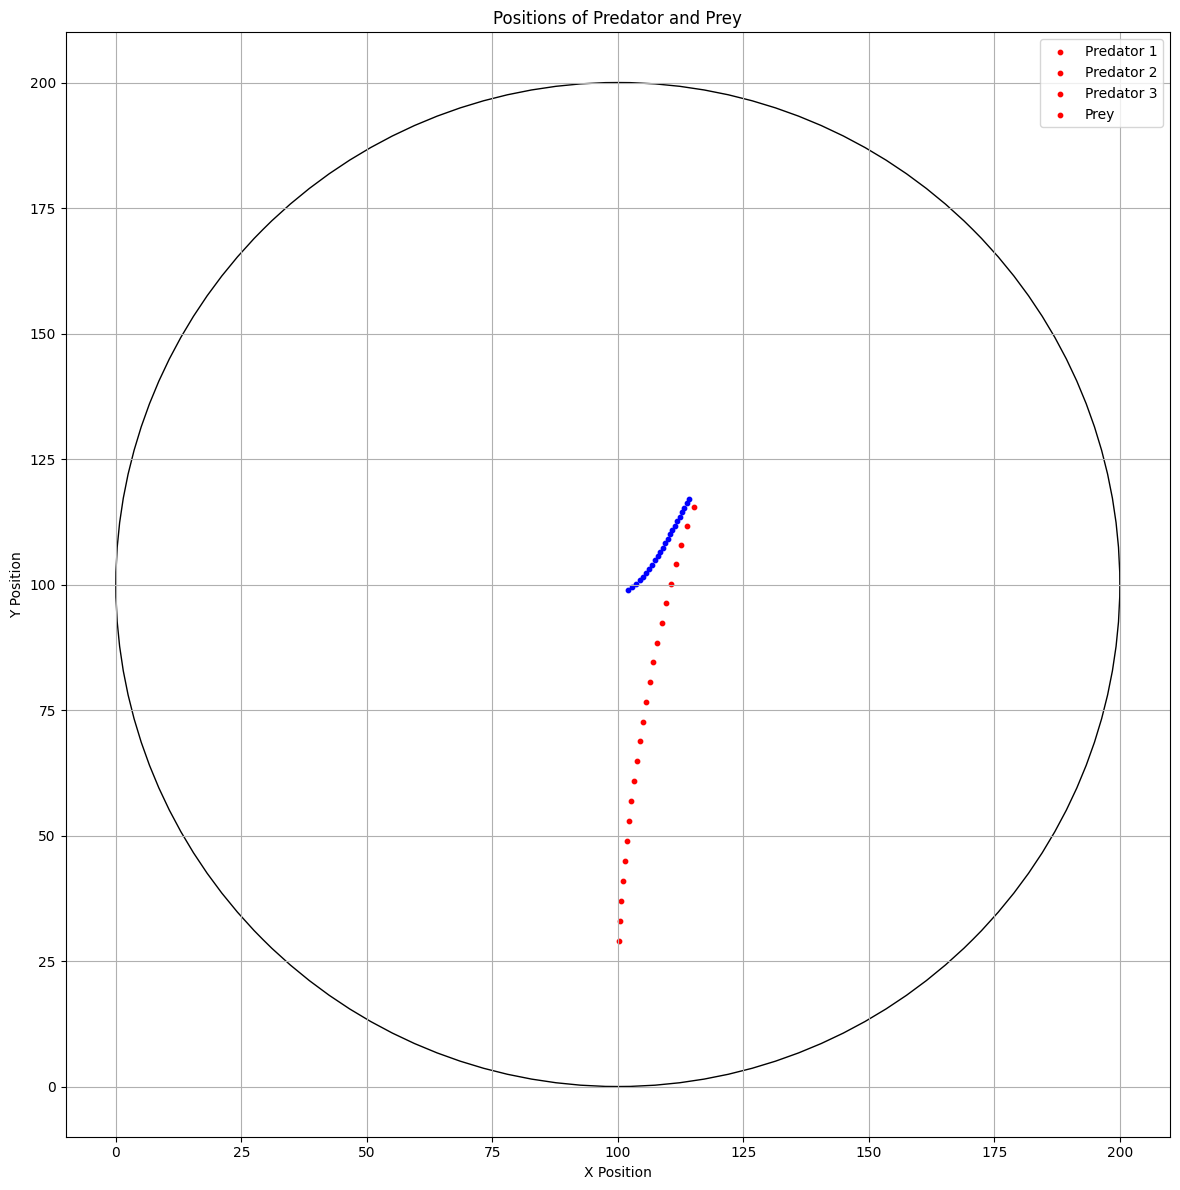

In [116]:
world.plot(0)

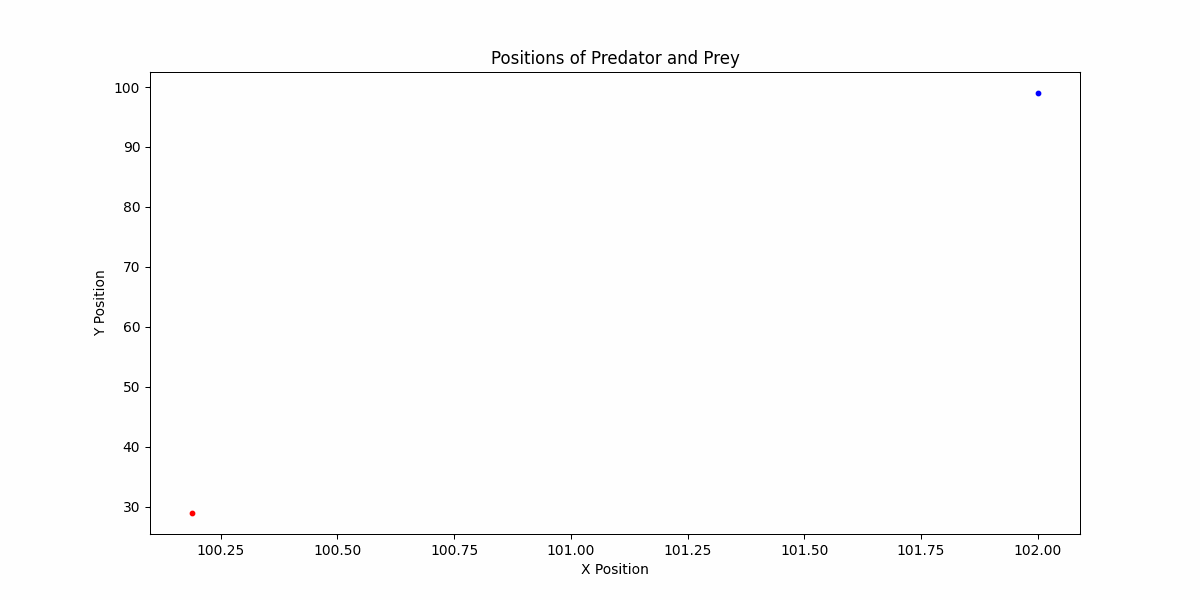

In [117]:
world.animate(0)

## Scenario 2 (3 vs 1 Triangle Trap)

In [131]:
num_episodes = 1000
max_steps = 300
min_distance = 2

predators2 = [Predator(position=(50,50)), Predator(position=(40,90)), Predator(position=(60,90))]
prey2 = Prey(position=(50,70), velocity=[1,0])
world2 = World(prey2, predators2, "world2")
world2.simulate(num_episodes, max_steps, min_distance)

Simulating..:   0%|          | 0/1000 [00:00<?, ?it/s]

Predator ate prey at step 211 in episode 3
Predator ate prey at step 33 in episode 4
Predator ate prey at step 37 in episode 5
Predator ate prey at step 34 in episode 6
Predator ate prey at step 36 in episode 7
Predator ate prey at step 104 in episode 8
Predator ate prey at step 84 in episode 11
Predator ate prey at step 145 in episode 136
Predator ate prey at step 17 in episode 137
Predator ate prey at step 18 in episode 138
Predator ate prey at step 20 in episode 139
Predator ate prey at step 19 in episode 140
Predator ate prey at step 22 in episode 141
Predator ate prey at step 24 in episode 142
Predator ate prey at step 25 in episode 143
Predator ate prey at step 26 in episode 144
Predator ate prey at step 26 in episode 145
Predator ate prey at step 26 in episode 146
Predator ate prey at step 26 in episode 147
Predator ate prey at step 26 in episode 148
Predator ate prey at step 26 in episode 149
Predator ate prey at step 27 in episode 150
Predator ate prey at step 27 in episode 15

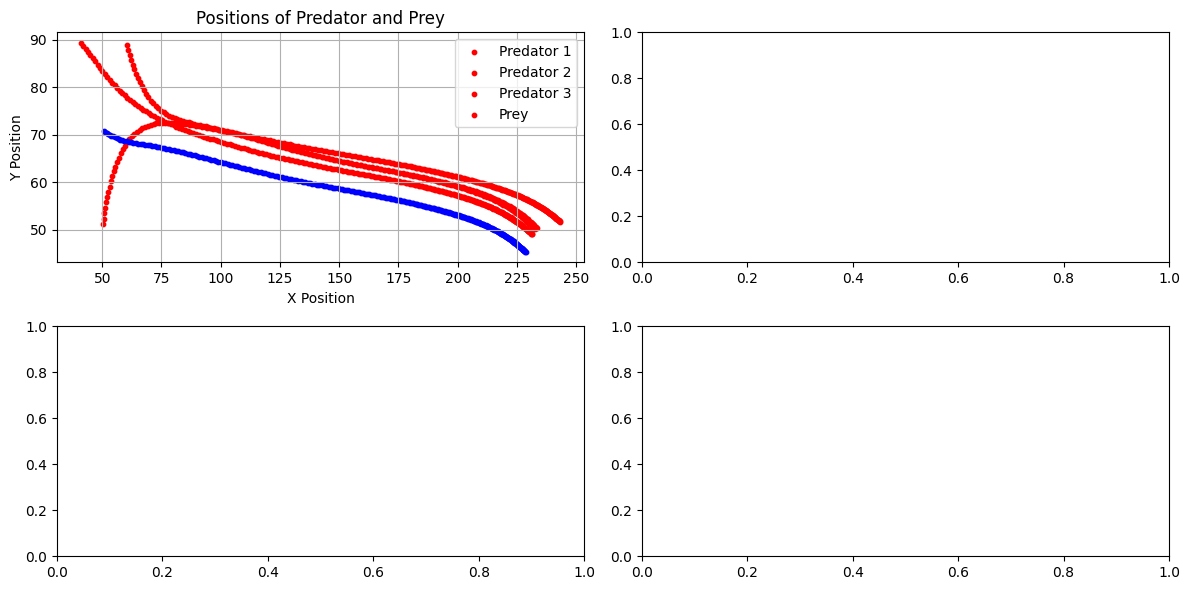

In [132]:
world2.plot(0)

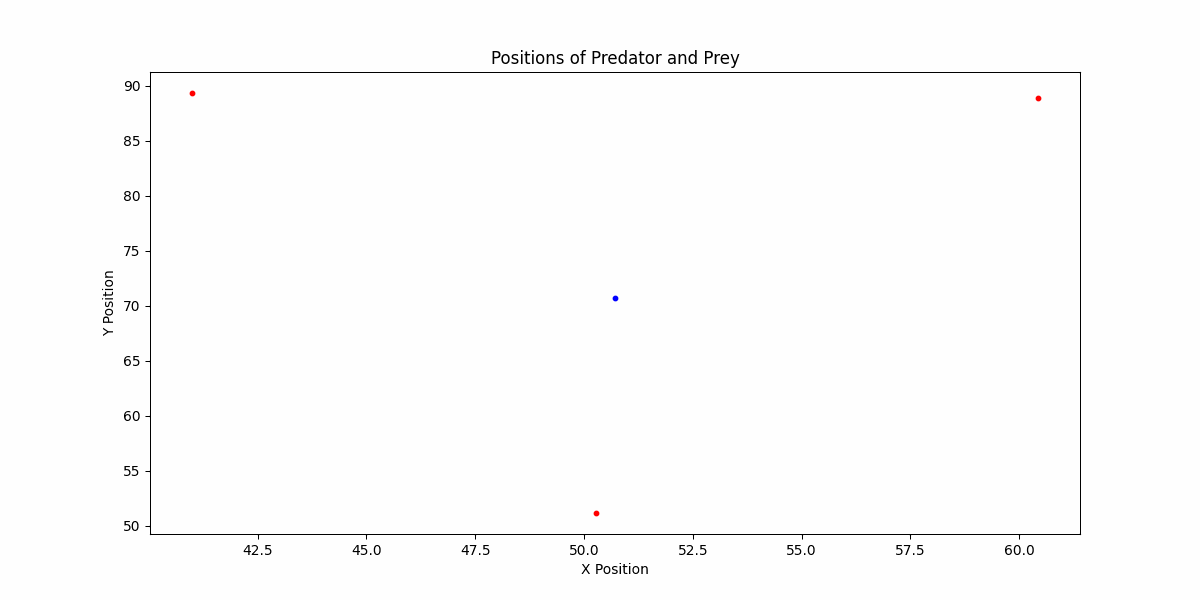

In [134]:
world2.animate(0)

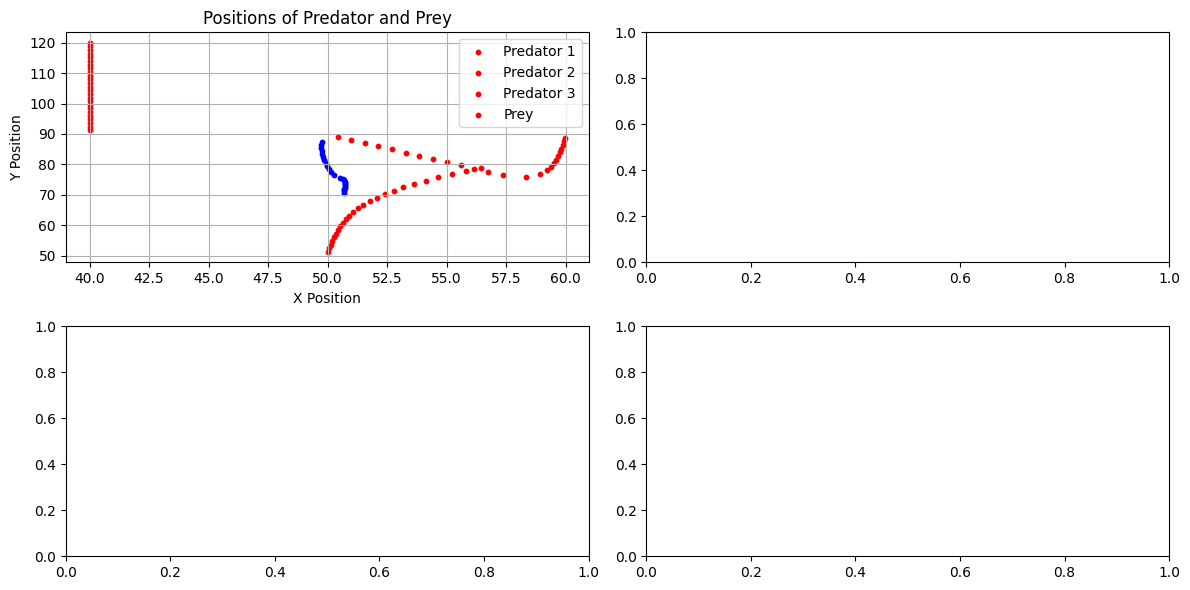

In [135]:
world2.plot(499)

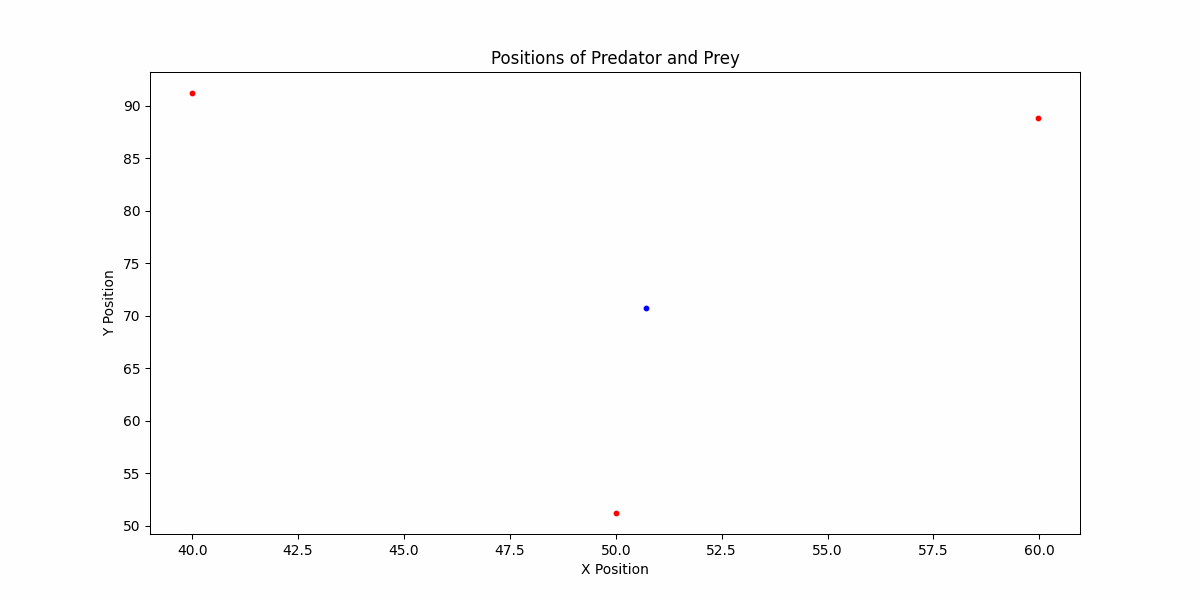

In [136]:
world2.animate(499)

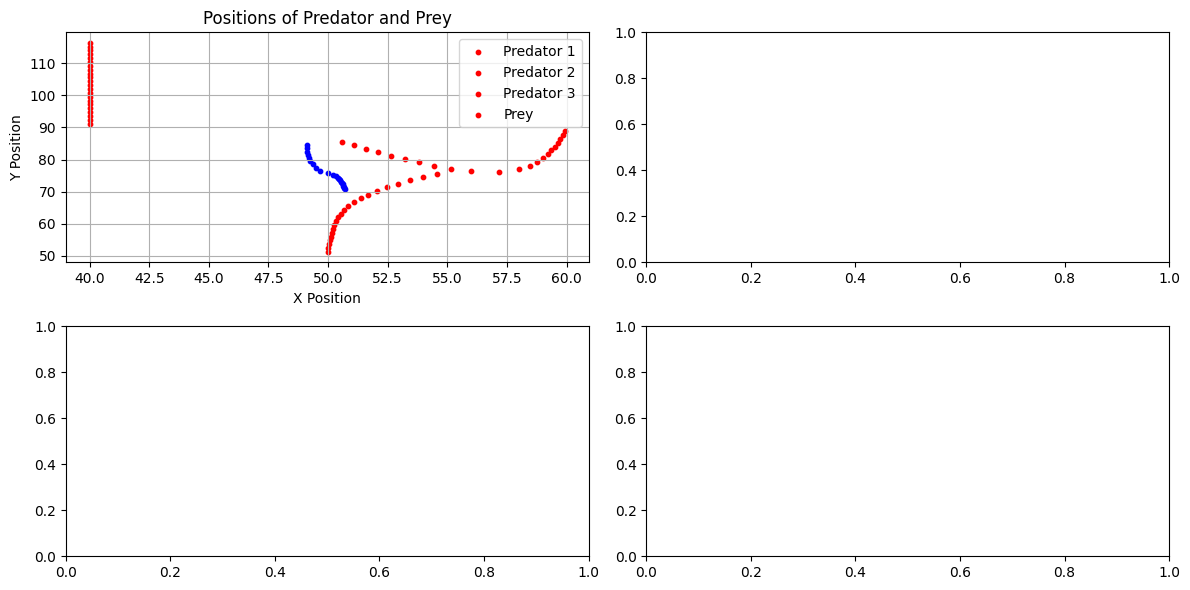

In [137]:
world2.plot(999)

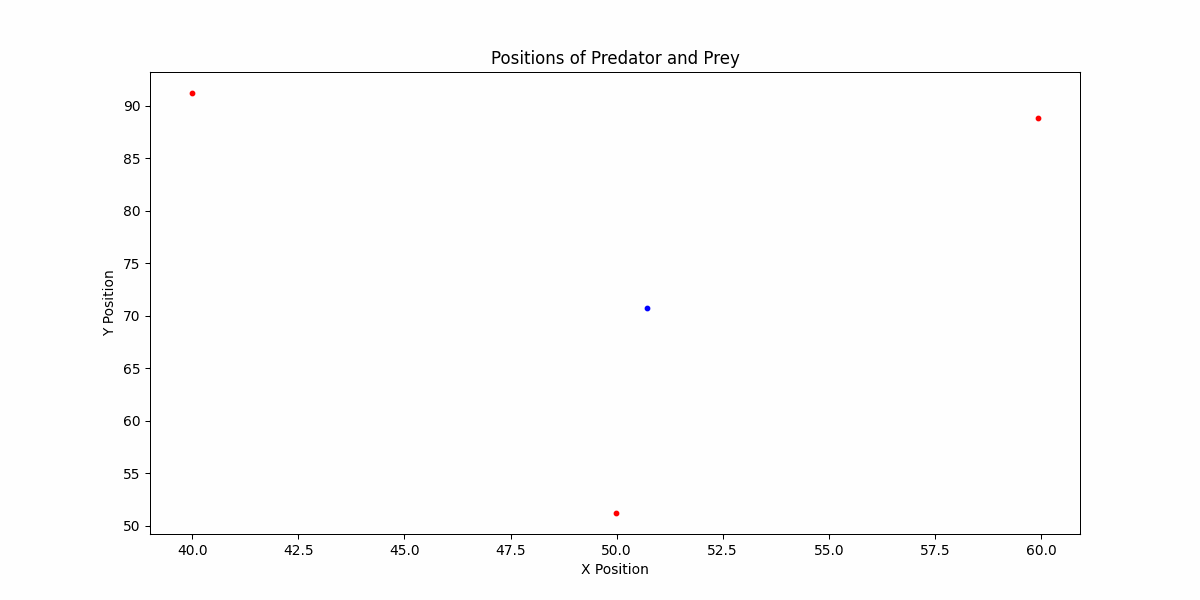

In [138]:
world2.animate(999)

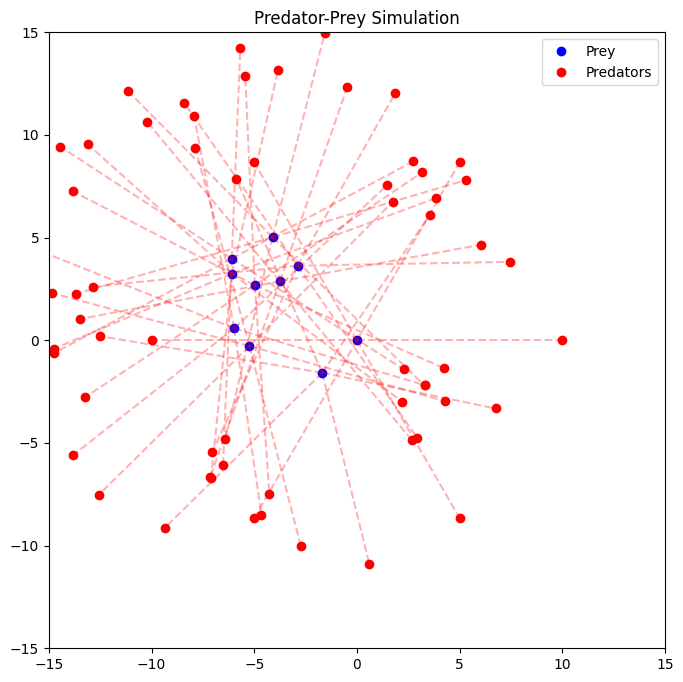

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Simulation parameters
NUM_PREDATORS = 6
PREDATOR_RADIUS = 0.5
PREY_RADIUS = 0.5
PREY_SPEED = 1.0
PREDATOR_SPEED = 0.5
CENTER_RADIUS = 10
TIME_STEPS = 100

# Initialize positions
prey_pos = np.array([0.0, 0.0])
predators = []
angles = np.linspace(0, 2 * np.pi, NUM_PREDATORS, endpoint=False)
for angle in angles:
    x = prey_pos[0] + CENTER_RADIUS * np.cos(angle)
    y = prey_pos[1] + CENTER_RADIUS * np.sin(angle)
    predators.append([x, y])
predators = np.array(predators)

# Discrete simulation
prey_positions = [prey_pos.copy()]
predator_positions = [predators.copy()]

for t in range(TIME_STEPS):
    # Prey movement (simple wandering behavior)
    prey_pos += np.random.uniform(-PREY_SPEED, PREY_SPEED, size=2)

    # Predator movement (circle prey)
    for i, predator in enumerate(predators):
        dx = prey_pos[0] - predator[0]
        dy = prey_pos[1] - predator[1]
        distance = np.sqrt(dx**2 + dy**2)

        # Maintain circular formation
        target_x = prey_pos[0] + CENTER_RADIUS * np.cos(angles[i])
        target_y = prey_pos[1] + CENTER_RADIUS * np.sin(angles[i])

        angle_to_target = np.arctan2(target_y - predator[1], target_x - predator[0])
        predator[0] += PREDATOR_SPEED * np.cos(angle_to_target)
        predator[1] += PREDATOR_SPEED * np.sin(angle_to_target)

        # Update angle to maintain formation
        angles[i] += 0.01

    # Record positions
    prey_positions.append(prey_pos.copy())
    predator_positions.append(predators.copy())

# Plot the simulation
fig, ax = plt.subplots(figsize=(8, 8))
for t in range(0, TIME_STEPS, 10):
    prey_pos = prey_positions[t]
    predators = predator_positions[t]

    # Plot prey
    ax.plot(prey_pos[0], prey_pos[1], 'bo', label='Prey' if t == 0 else "")

    # Plot predators
    ax.plot(predators[:, 0], predators[:, 1], 'ro', label='Predators' if t == 0 else "")

    # Connect predators to form a circle
    for predator in predators:
        ax.plot([prey_pos[0], predator[0]], [prey_pos[1], predator[1]], 'r--', alpha=0.3)

ax.set_xlim(-CENTER_RADIUS - 5, CENTER_RADIUS + 5)
ax.set_ylim(-CENTER_RADIUS - 5, CENTER_RADIUS + 5)
ax.set_aspect('equal')
ax.legend()
plt.title("Predator-Prey Simulation")
plt.show()